In [33]:
import networkx as nx
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
from tueplots import bundles

plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({'figure.dpi': 200})

In [34]:
def drop_one_student_course(data):
    df = data.loc[:,["mellon_id","course_id"]].copy()
    df = df.groupby("course_id")['mellon_id'].apply(list).reset_index()
    df.columns = ["course_id","mellon_id_list"]
    df["course_size"] = df["mellon_id_list"].apply(len)
    one_stud_courses = df.loc[df["course_size"]>1,"course_id"].to_list()
    return data.loc[data["course_id"].isin(one_stud_courses)]

def stud_by_course_matrix(df):

    student_u = CategoricalDtype(sorted(df["mellon_id"].unique()), ordered=True) 
    course_u = CategoricalDtype(sorted(df["course_id"].unique()), ordered=True) 

    row = df["mellon_id"].astype(student_u).cat.codes
    col = df["course_id"].astype(course_u).cat.codes
    sparse_matrix = csr_matrix((df["total"], (row, col)), shape=(student_u.categories.size, course_u.categories.size))
    print(f"Average number of courses: {sparse_matrix.sum(axis=1).mean() }")
    print(f"Shape of Adjacency matrix: {sparse_matrix.shape}")
    return sparse_matrix, student_u.categories.to_list(), course_u.categories.to_list()

def stud_by_stud_matrix(data):
    adj,stud_ids,course_ids = stud_by_course_matrix(data)
    adj_stud = (adj @ adj.T).A
    np.fill_diagonal(adj_stud,0)
    return adj_stud,stud_ids,course_ids

def get_assortativity_coef(df1_year,years,attributes):
    coefs = {attribute:[] for attribute in attributes}
    coefs["stem"] = []
    stem_info = df1_year.loc[:,["mellon_id","year","major_stem_1"]].groupby(["mellon_id","year"]).mean().reset_index()
    for year in years:
        print(year)
        adj,stud_ids,course_ids = stud_by_stud_matrix(df1_year.loc[df1_year.year == year])
        G = nx.from_numpy_array(adj)
        for attribute in attributes:
            attr_dict = demo.loc[stud_ids,attribute].reset_index(drop=True).to_dict()
            nx.set_node_attributes(G, attr_dict, attribute)
            coef = nx.attribute_assortativity_coefficient(G,attribute)
            coefs[attribute].append(coef)
        
        stem_year = stem_info.loc[stem_info["year"]==year].set_index("mellon_id")
        attr_dict = stem_year.loc[stud_ids,"major_stem_1"].reset_index(drop=True).to_dict()
        nx.set_node_attributes(G, attr_dict, "stem")
        coef = nx.attribute_assortativity_coefficient(G,"stem")
        coefs["stem"].append(coef)
    return coefs

def plot_coefs(coefs,years):
      fig, ax = plt.subplots(1, 4, figsize=(12, 3))
      years_str = [str(y) for y in years]
      ax[0].plot(years_str,coefs["female"])
      ax[0].set_title("Gender")
      ax[0].grid()
      ax[0].set_ylabel("Assortativity coefficient")

      ax[1].plot(years_str,coefs["low_income_desc"])
      ax[1].set_title("Low Income")
      ax[1].grid()

      ax[2].plot(years_str,coefs["URM"])
      ax[2].set_title("Underrepresented minority")
      ax[2].grid()

      ax[3].plot(years_str,coefs["stem"])
      ax[3].set_title("STEM")
      ax[3].grid()
      plt.show()

## 1. Node Assortativity Coefficients and Correlation Measures

We compare the networks for the first, second, third, fourth years of study. Does the assortativity coefficient change over time? 

Assortativity measures the similarity of connections in the graph with respect to the given attribute.

The networks are clustered by:

1) Low-income vs not low-income

2) Female and male networks

3) URM and non-URM

In [35]:
df1 = pd.read_pickle("../Data/for_network/df1.pkl")
df2 = pd.read_pickle("../Data/for_network/df2.pkl")
demo = pd.read_pickle("../Data/for_network/demo.pkl")
df2_info = pd.read_pickle("../Data/for_network/df2_info.pkl")

demo = demo.dropna(subset=["female","low_income_desc","URM"])
demo = demo.set_index("mellon_id")
df2 = df2.dropna(subset=["major_stem_1"])

def prep_datasets(year_c):
      cohort_year = df2.loc[df2["freshmen_"+str(year_c)]==1,"mellon_id"].unique()
      cohort_year = demo.loc[demo.index.isin(cohort_year)].index.to_list()

      df1_cohort = df1.loc[df1["mellon_id"].isin(cohort_year)].copy()
      df1_cohort["total"]=1
      
      stem = (df2.loc[
                  df2["mellon_id"].isin(cohort_year),
                  ["mellon_id","major_stem_1","year"]
                  ]
                  .groupby(["mellon_id","year"])
                  .mean()
                  .reset_index()
            )
      stem["major_stem_1"] = 1*(stem["major_stem_1"] > 0.5)

      df1_cohort = df1_cohort.merge(stem,how="inner",on=["mellon_id","year"])
      return df1_cohort


In [36]:
years_dict = {201692:[2016,2017,2018,2019],
            201192:[2011,2012,2013,2014],
            201292:[2012,2013,2014,2015],
            201392:[2013,2014,2015,2016],
            201492:[2014,2015,2016,2017],
            201592:[2015,2016,2017,2018] }
attributes = ["female","low_income_desc","URM"]
cohorts_coefs = {}

for year_c in years_dict.keys():
    print("COHORT ",year_c)
    df1_year = prep_datasets(year_c)
    coefs = get_assortativity_coef(df1_year,years_dict[year_c],attributes)
    cohorts_coefs[year_c] = coefs

COHORT  201692
2016
Average number of courses: 19.16140199048031
Shape of Adjacency matrix: (4622, 6006)
2017
Average number of courses: 18.475
Shape of Adjacency matrix: (4280, 8467)
2018
Average number of courses: 13.810650887573965
Shape of Adjacency matrix: (4056, 6620)
2019
Average number of courses: 10.1784494086728
Shape of Adjacency matrix: (3805, 4978)
COHORT  201192
2011
Average number of courses: 19.007465007776048
Shape of Adjacency matrix: (3215, 4837)
2012
Average number of courses: 19.42075292628915
Shape of Adjacency matrix: (3161, 7041)
2013
Average number of courses: 17.249839846252403
Shape of Adjacency matrix: (3122, 7999)
2014
Average number of courses: 14.898014136654325
Shape of Adjacency matrix: (2971, 7917)
COHORT  201292
2012
Average number of courses: 19.16533409480297
Shape of Adjacency matrix: (3502, 5033)
2013
Average number of courses: 18.750799651061357
Shape of Adjacency matrix: (3439, 7259)
2014
Average number of courses: 16.965506621496765
Shape of Ad

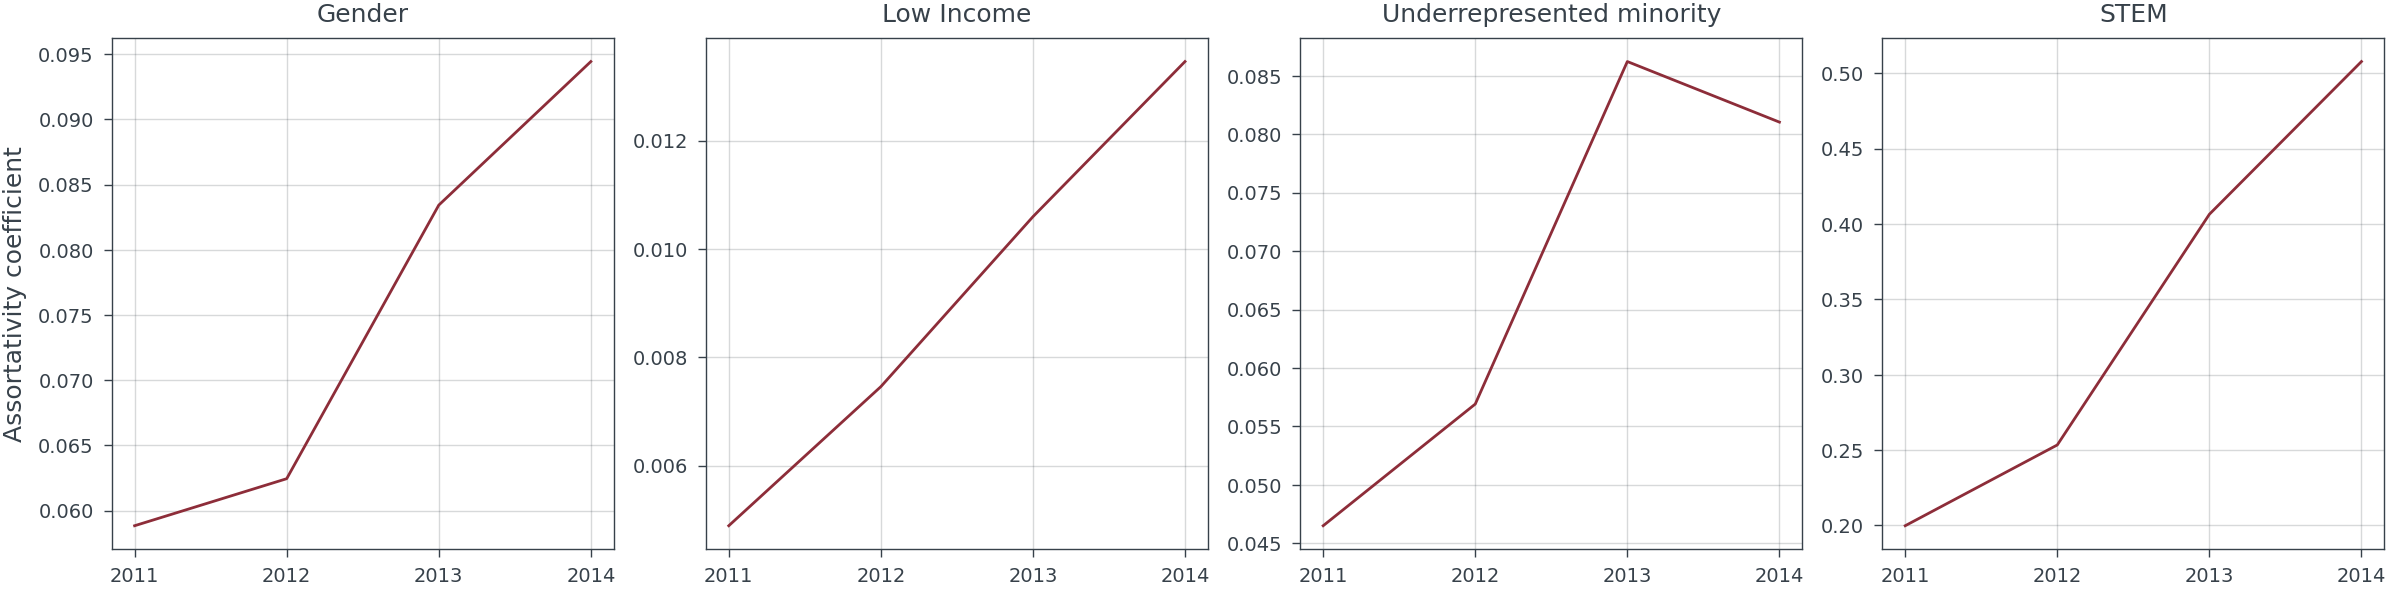

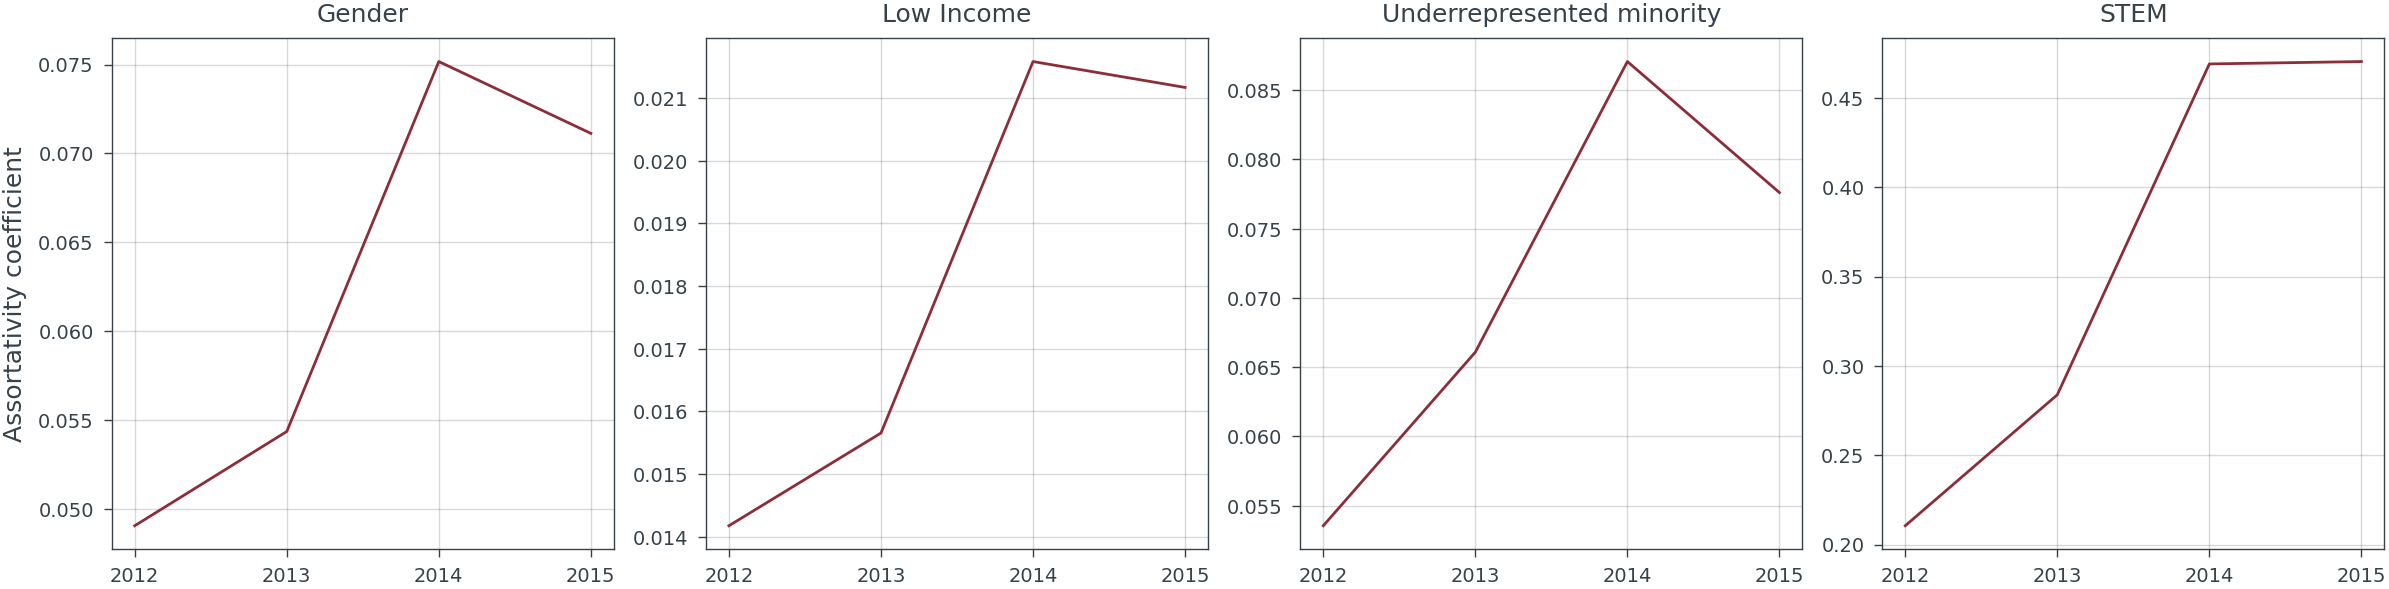

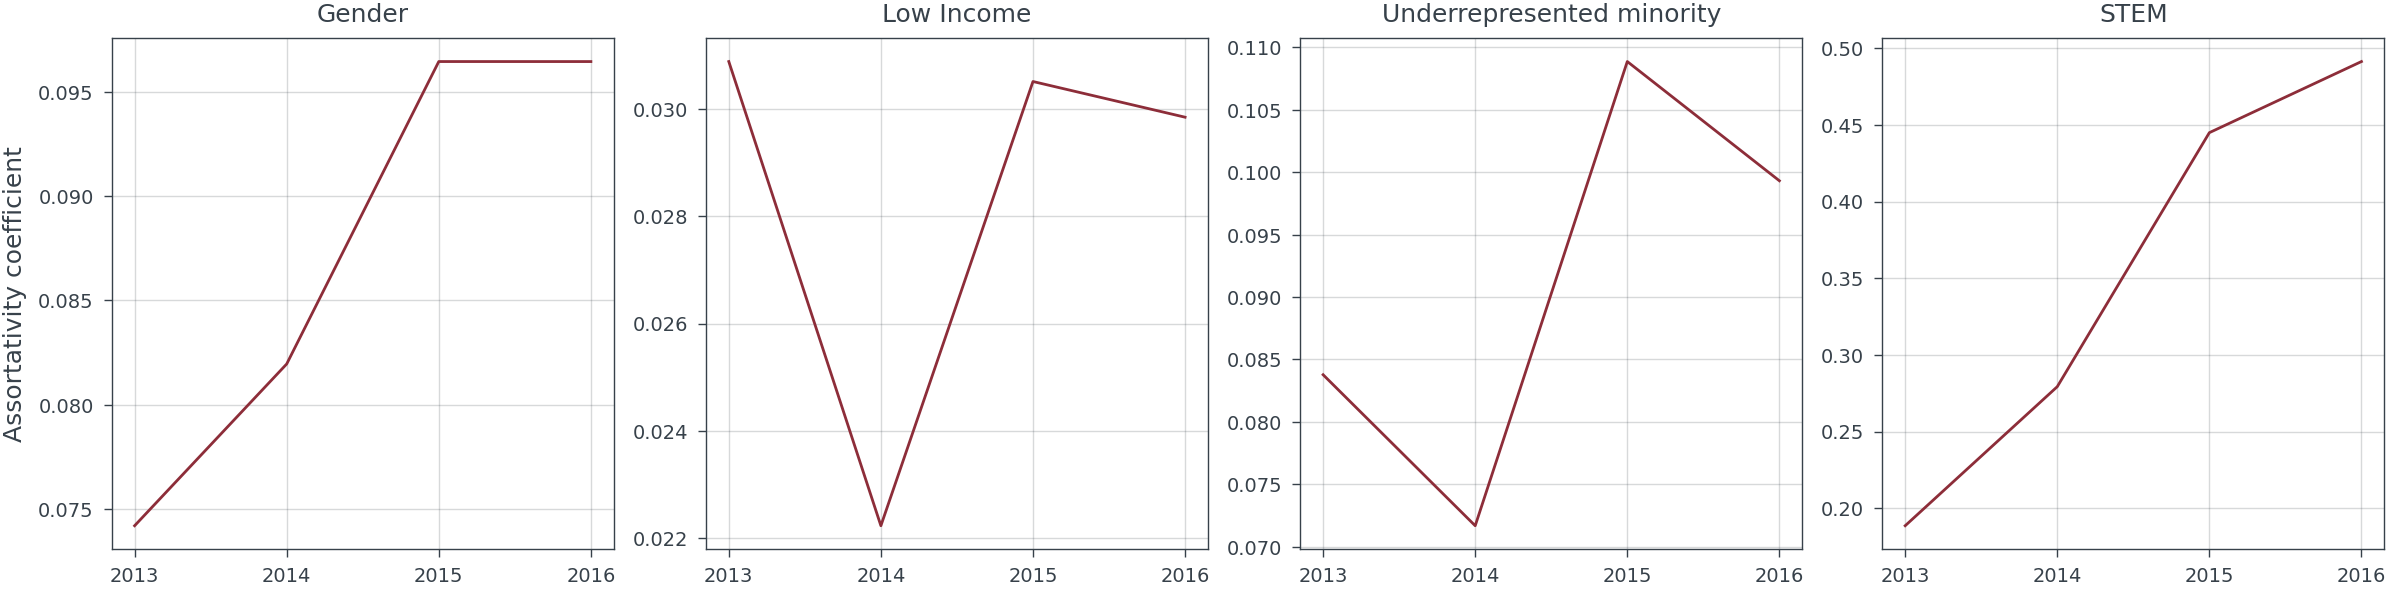

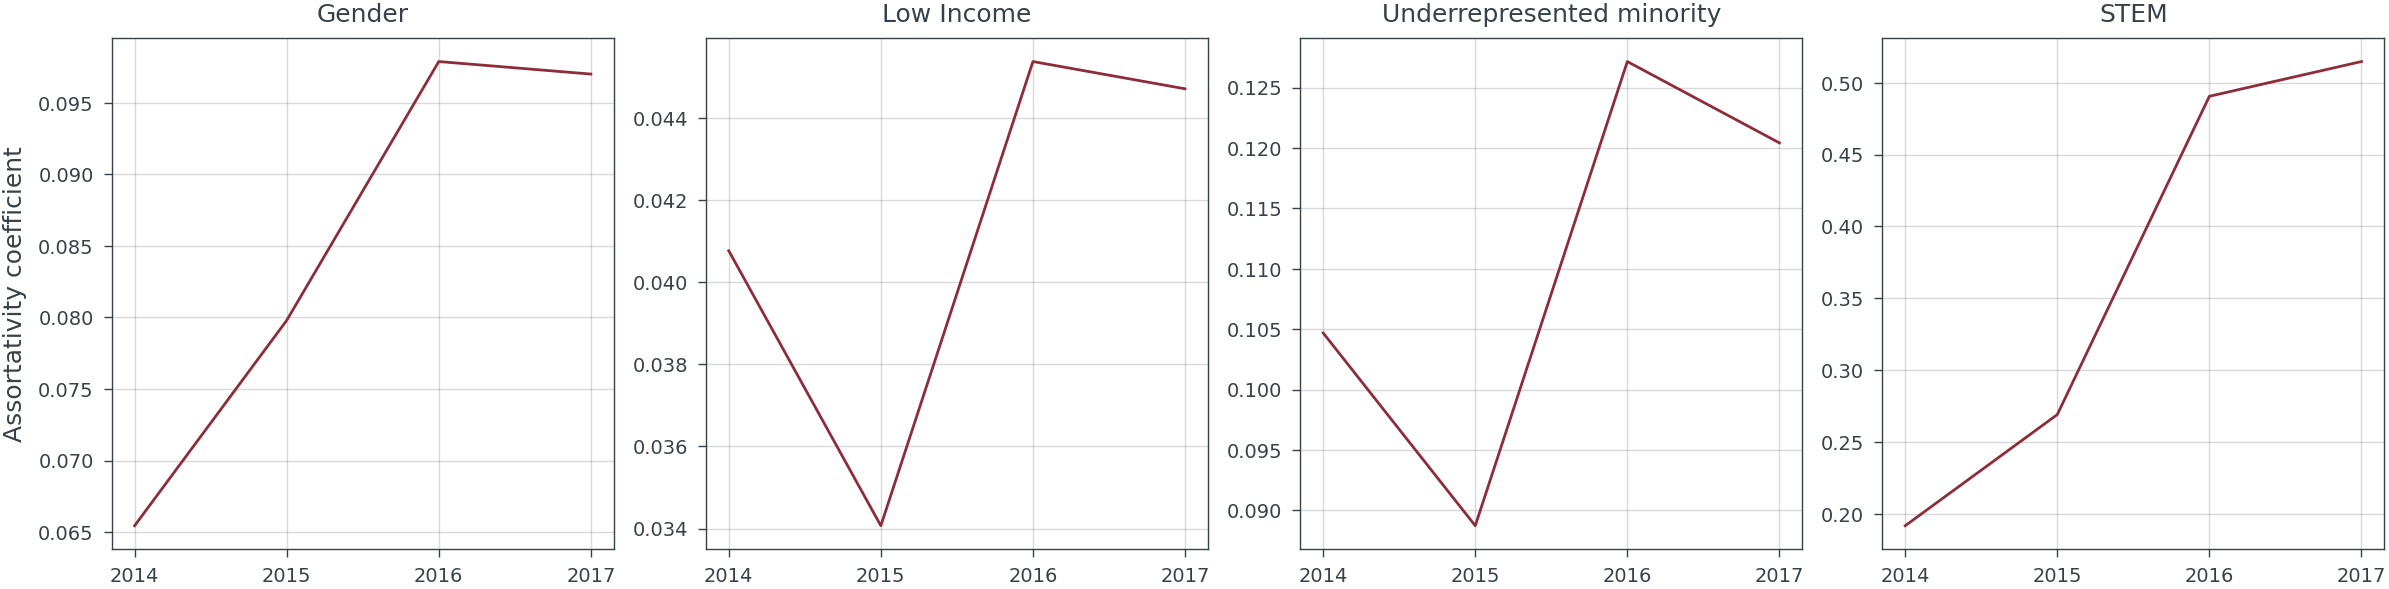

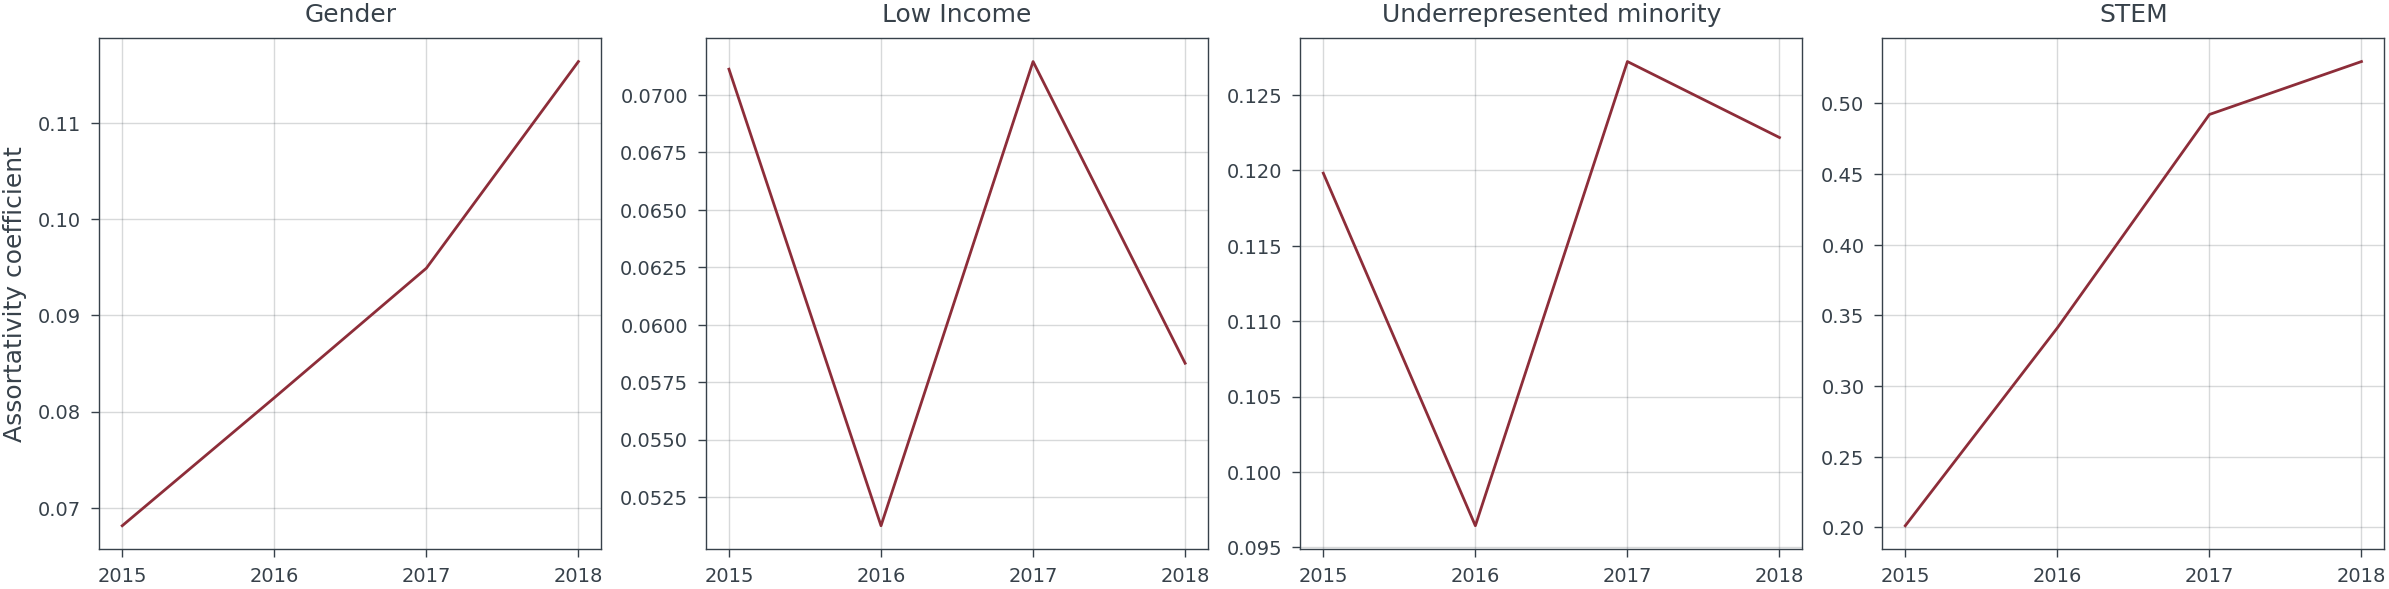

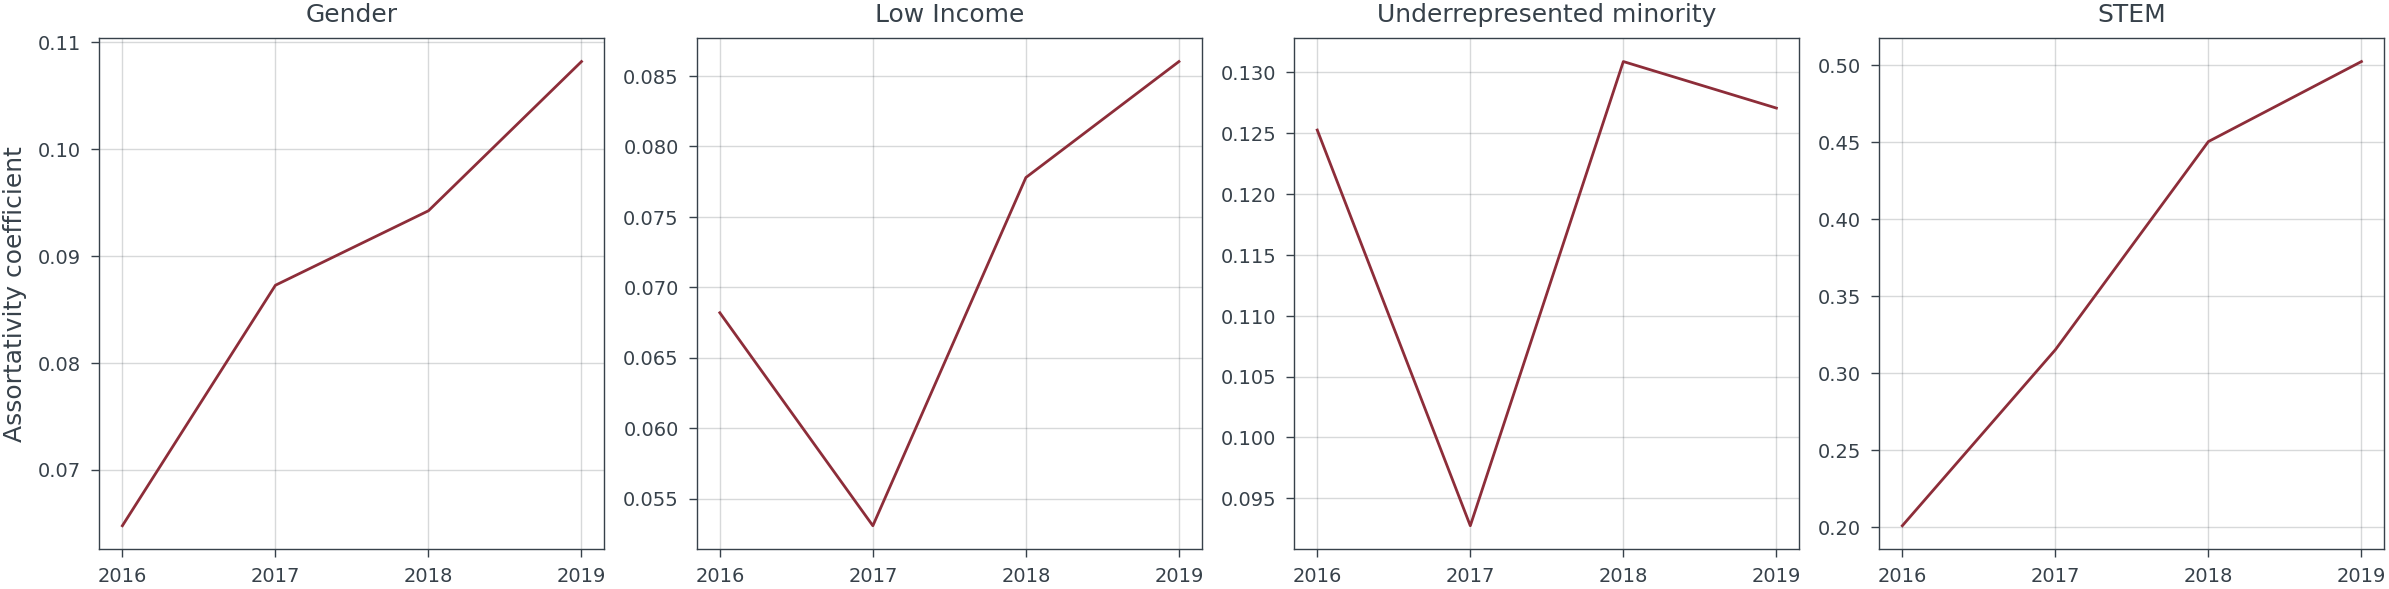

In [37]:
plot_coefs(cohorts_coefs[201192],years_dict[201192])
plot_coefs(cohorts_coefs[201292],years_dict[201292])
plot_coefs(cohorts_coefs[201392],years_dict[201392])
plot_coefs(cohorts_coefs[201492],years_dict[201492])
plot_coefs(cohorts_coefs[201592],years_dict[201592])
plot_coefs(cohorts_coefs[201692],years_dict[201692])

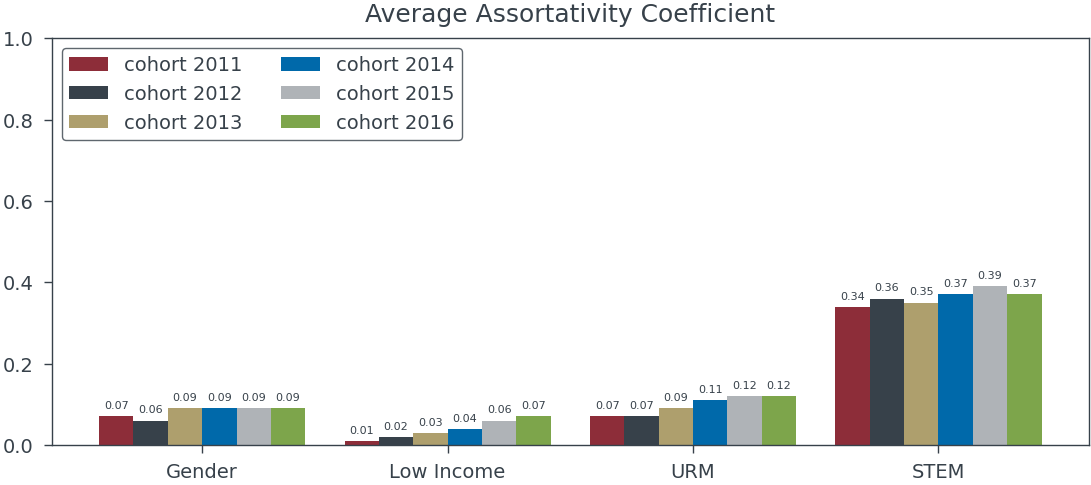

In [38]:
attributes = ("female", "low_income_desc", "URM","stem")
cohort_means = {
    'cohort 2011': [round(np.mean(cohorts_coefs[201192][attr]),2) for attr in attributes],
    'cohort 2012': [round(np.mean(cohorts_coefs[201292][attr]),2) for attr in attributes],
    'cohort 2013': [round(np.mean(cohorts_coefs[201392][attr]),2) for attr in attributes],
    'cohort 2014': [round(np.mean(cohorts_coefs[201492][attr]),2) for attr in attributes],
    'cohort 2015': [round(np.mean(cohorts_coefs[201592][attr]),2) for attr in attributes],
    'cohort 2016': [round(np.mean(cohorts_coefs[201692][attr]),2) for attr in attributes]
}

x = np.arange(len(attributes))  # the label locations
width = 0.14 # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for cohort, measurement in cohort_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=cohort)
    ax.bar_label(rects, padding=2,fontsize=4)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
#ax.set_ylabel('Assortativity Coefficient')
ax.set_title('Average Assortativity Coefficient')
ax.set_xticks(x + 2.5*width, ["Gender","Low Income","URM","STEM"])
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(0, 1)

plt.show()

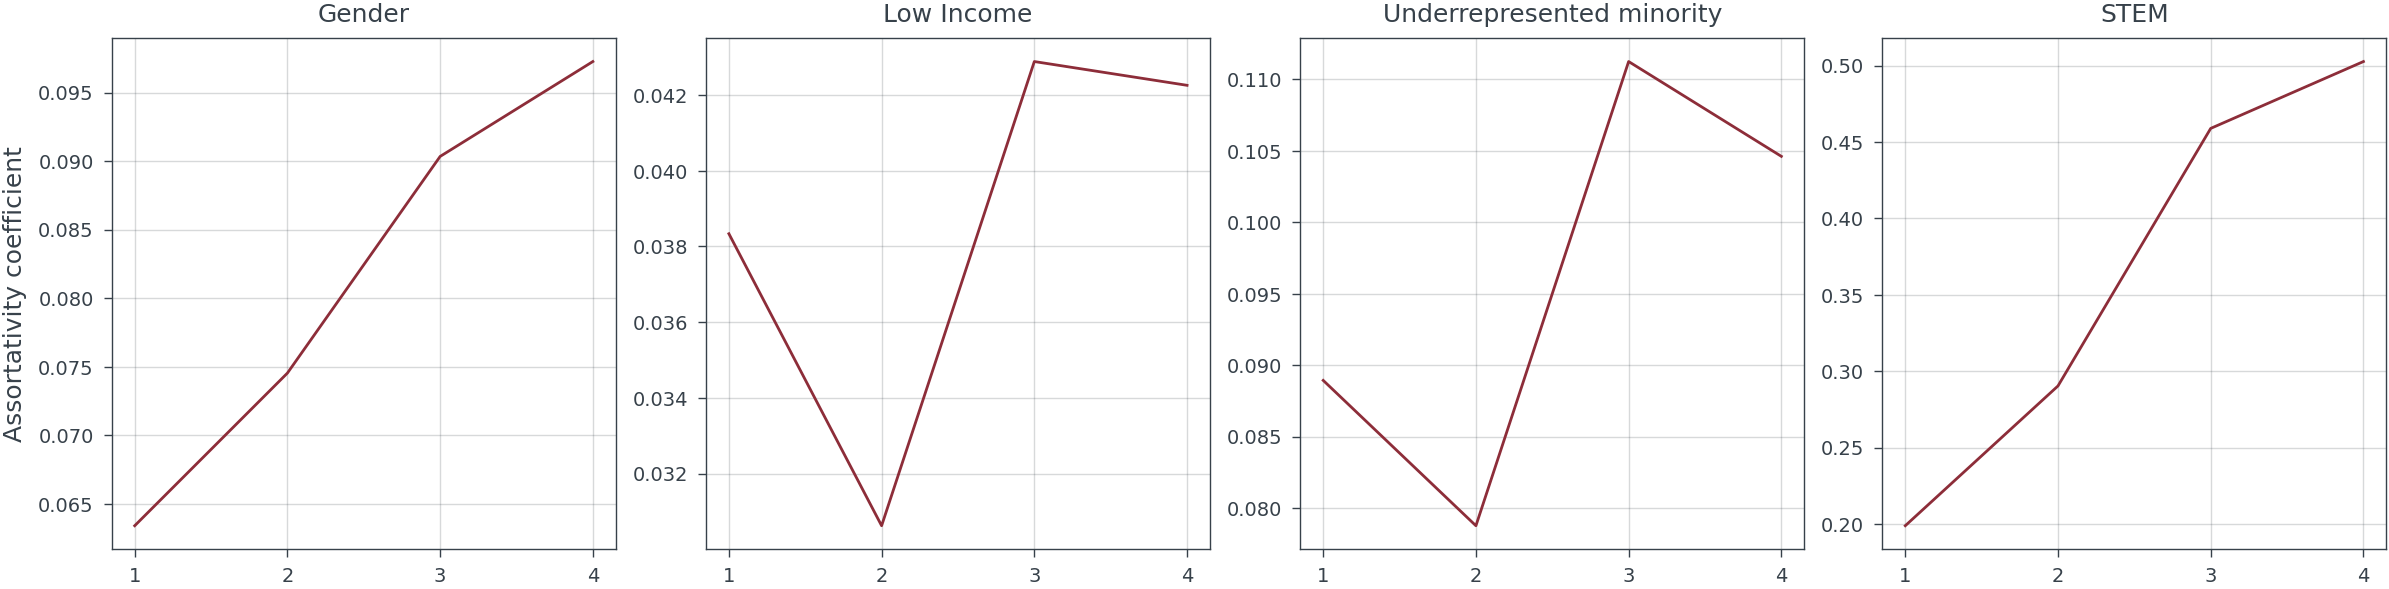

In [39]:
average_cohorts_coefs = {attr:0 for attr in attributes}
for year,attrs in cohorts_coefs.items():
    for attr,coefs in attrs.items():
        average_cohorts_coefs[attr] = average_cohorts_coefs[attr] + np.array(coefs)

for attr,coefs in average_cohorts_coefs.items():
    average_cohorts_coefs[attr] = coefs/6

plot_coefs(average_cohorts_coefs,[1,2,3,4])

# Transfer

In [87]:
def prep_dataset_transf(year,status):
      cohort_year = df2.loc[(df2["year"]==year)&(df2["year_study"]==status),"mellon_id"].unique()
      cohort_year = demo.loc[demo.index.isin(cohort_year)].index.to_list()

      df1_cohort = df1.loc[(df1["mellon_id"].isin(cohort_year)) & (df1["year"]==year)].copy()
      df1_cohort["total"]=1
      
      #stem = (df2.loc[
      #            df2["mellon_id"].isin(cohort_year),
      #            ["mellon_id","major_stem_1","year"]
      #            ]
      #            .groupby(["mellon_id","year"])
      #            .mean()
      #            .reset_index()
      #      )
      #stem["major_stem_1"] = 1*(stem["major_stem_1"] > 0.5)

      #df1_cohort = df1_cohort.merge(stem,how="inner",on=["mellon_id","year"])
      return df1_cohort

def get_assortativity_coef_transf(df1_year,attributes):

    #stem_info = df1_year.loc[:,["mellon_id","year","major_stem_1"]].groupby(["mellon_id","year"]).mean().reset_index().set_index("mellon_id")
    coefs = {}
    adj,stud_ids,course_ids = stud_by_stud_matrix(df1_year)
    G = nx.from_numpy_array(adj)
    for attribute in attributes:
        attr_dict = demo.loc[stud_ids,attribute].reset_index(drop=True).to_dict()
        nx.set_node_attributes(G, attr_dict, attribute)
        coef = nx.attribute_assortativity_coefficient(G,attribute)
        coefs[attribute]= coef
        
        #attr_dict = stem_info.loc[stud_ids,"major_stem_1"].reset_index(drop=True).to_dict()
        #nx.set_node_attributes(G, attr_dict, "stem")
        #coef = nx.attribute_assortativity_coefficient(G,"stem")
        #coefs["stem"] = coef
    return coefs

def plot_coefs(df,statuses):
      fig, ax = plt.subplots(1, 4, figsize=(12, 3))
      ax[0].plot(statuses,df["female"])
      ax[0].set_title("Gender")
      ax[0].grid()
      ax[0].set_ylabel("Assortativity coefficient")

      ax[1].plot(statuses,df["low_income_desc"])
      ax[1].set_title("Low Income")
      ax[1].grid()

      ax[2].plot(statuses,df["URM"])
      ax[2].set_title("Underrepresented minority")
      ax[2].grid()

      ax[3].plot(statuses,df["transferred_2017_sophomore"])
      ax[3].set_title("transferred_2017_sophomore")
      ax[3].grid()

      plt.show()

In [92]:
df1 = pd.read_pickle("../Data/for_network/df1.pkl")
df2 = pd.read_pickle("../Data/for_network/df2.pkl")
demo = pd.read_pickle("../Data/for_network/demo.pkl")
df2_info = pd.read_pickle("../Data/for_network/df2_info.pkl")
#df2_info = df2_info.loc[df2_info["total_num_terms"]>=3]
print(demo.shape)
print(df2_info.shape)
print(df2.shape)


(101704, 6)
(137402, 22)
(1114038, 26)


In [78]:
df2["transferred_2017_sophomore"] = 1*(df2["freshmen_201692"]==0)*((df2["year_study"]=="Sophomore") & (df2["year"]==2017))
df2["transferred_2017_sophomore"].sum()

10450

In [80]:
transf = df2.loc[(df2["transferred_2017_sophomore"]==1)|(df2["freshmen_201692"]==1)].reset_index(drop=True)
df2.drop("transferred_2017_sophomore",axis=1,inplace=True)
transf.shape

(63151, 27)

In [81]:
transf = transf.loc[:,["mellon_id","transferred_2017_sophomore"]].groupby("mellon_id").sum().reset_index()
transf["transferred_2017_sophomore"] = 1*(transf["transferred_2017_sophomore"]>0)
demo = demo.merge(transf.loc[:,["mellon_id","transferred_2017_sophomore"]],how="inner",on="mellon_id")
demo.shape

(10559, 7)

In [82]:
print(len(demo["mellon_id"].unique()))
demo=demo.set_index("mellon_id")

10559


In [83]:
demo["transferred_2017_sophomore"].sum()

5735

In [75]:
df2_info["freshmen_201692"].sum()

4824

In [89]:
years = [2017,2018,2019]
statuses = ["Sophomore","Junior","Senior"]
attributes = ["female","low_income_desc","URM","transferred_2017_sophomore"]
cohorts_coefs = {}

orig_2016_transf_soph_2017 = demo.index.to_list()

for year,status in zip(years,statuses):
    print(status)
    df1_year = df1.loc[(df1["mellon_id"].isin(orig_2016_transf_soph_2017)) & (df1["year"]==year)].copy()
    df1_year["total"]=1
    coefs = get_assortativity_coef_transf(df1_year,attributes)
    cohorts_coefs[status] = coefs

df = {attr: [cohorts_coefs[status][attr] for status in statuses] for attr in attributes}

Sophomore
Average number of courses: 19.083637080090632
Shape of Adjacency matrix: (10151, 9875)
Junior
Average number of courses: 14.027340513670257
Shape of Adjacency matrix: (9656, 8017)
Senior
Average number of courses: 11.048980933596319
Shape of Adjacency matrix: (9126, 6612)


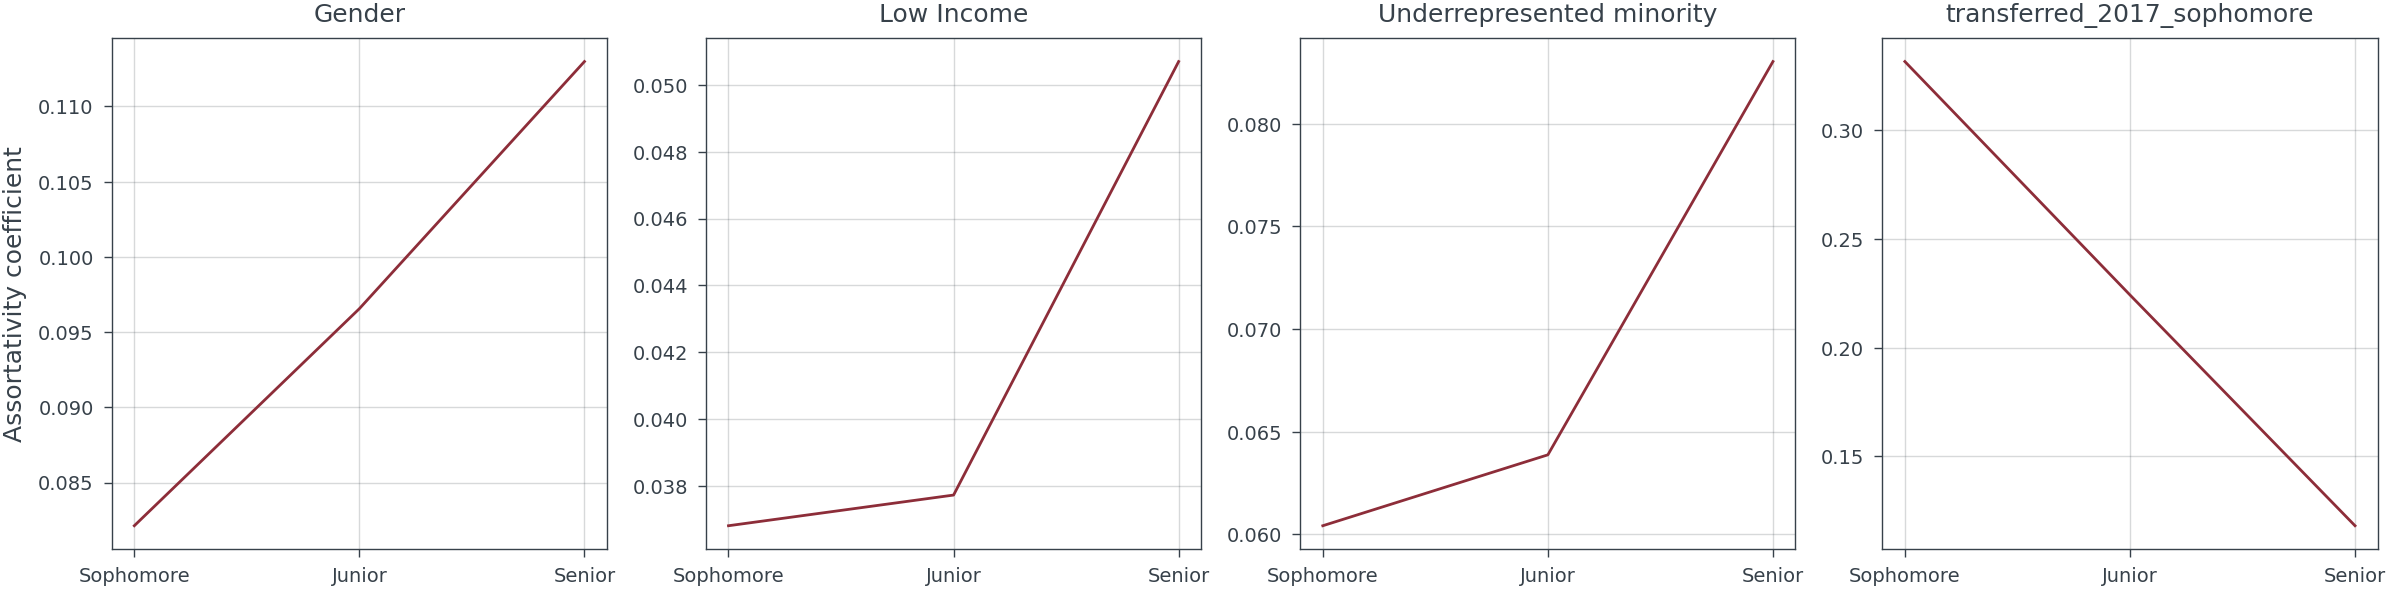

In [90]:
plot_coefs(df,statuses)

In [19]:
df1 = pd.read_pickle("../Data/for_network/df1.pkl")
df2 = pd.read_pickle("../Data/for_network/df2.pkl")
df2_info = pd.read_pickle("../Data/for_network/df2_info.pkl")
#df2_info = df2_info.loc[df2_info["total_num_terms"]>=3]
print(df2_info.shape)

(137402, 9)


In [25]:
df2.loc[df2["mellon_id"]==162767].head(50)

,mellon_id,term_code,major_change,gpa_term,gpa_cumulative,major_stem_1,major_name_1,major_school_name_1,US_citizen,year_study,freshman_term,year
13,162767,201892,0.0,3.43,3.43,0.0,Nursing Science,School of Nursing,1.0,Freshman,201892.0,2018
14,162767,201903,0.0,3.10,3.27,0.0,Nursing Science,School of Nursing,1.0,Freshman,201892.0,2018
15,162767,201914,0.0,3.23,3.26,0.0,Nursing Science,School of Nursing,1.0,Sophomore,201892.0,2018
17,162767,201992,0.0,3.33,3.31,0.0,Nursing Science,School of Nursing,1.0,Sophomore,201892.0,2019
18,162767,202003,0.0,3.53,3.35,0.0,Nursing Science,School of Nursing,1.0,Sophomore,201892.0,2019
19,162767,202014,0.0,3.65,3.41,0.0,Nursing Science,School of Nursing,1.0,Junior,201892.0,2019
21,162767,202092,0.0,3.81,3.48,0.0,Nursing Science,School of Nursing,1.0,Junior,201892.0,2020
22,162767,202103,0.0,3.57,3.49,0.0,Nursing Science,School of Nursing,1.0,Junior,201892.0,2020
23,162767,202114,0.0,3.63,3.51,0.0,Nursing Science,School of Nursing,1.0,Senior,201892.0,2020
24,162767,202192,0.0,3.84,3.54,0.0,Nursing Science,School of Nursing,1.0,Senior,201892.0,2021


In [27]:
df2_info.loc[df2_info["freshman_term"]==201692].shape

(4714, 9)

In [32]:
df = df2.merge(df2_info.loc[:,["mellon_id","graduated","transferred","last_gpa_cum","total_num_terms"]],how="inner",on="mellon_id")
#df = df.loc[df.year.isin([2016,2017,2018,2019])]
df = df.loc[:,["mellon_id","year","year_study","transferred"]].groupby(["mellon_id","year"]).first().reset_index()
df["total"] = 1
df = df.groupby(["year","year_study","transferred"]).sum().reset_index()
df = df.set_index(["year","year_study"])
df = df.loc[[(2016,"Freshman"),(2017,"Sophomore"),(2018,"Junior"),(2019,"Senior")]].reset_index()
df

,year,year_study,transferred,mellon_id,total
0,2016,Freshman,0,1009074081,4854
1,2017,Sophomore,0,776953652,4013
2,2017,Sophomore,1,413995547,2143
3,2018,Junior,0,697710263,3788
4,2018,Junior,1,826701715,4447
5,2019,Senior,0,800829464,4368
6,2019,Senior,1,1225229199,6650


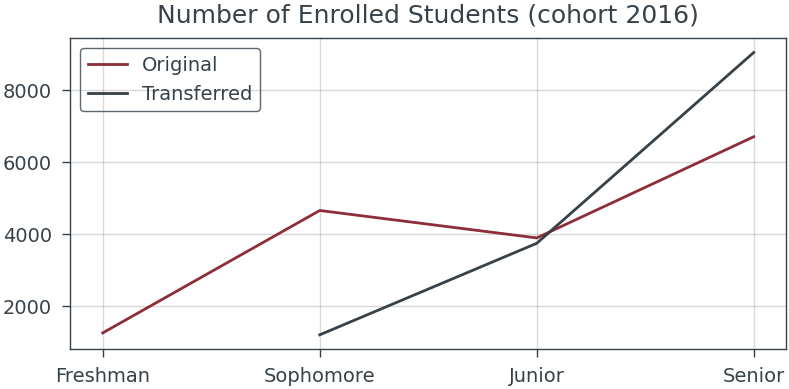

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
transf = df.loc[df["transferred"]==1]
orig = df.loc[df["transferred"]==0]
ax.plot(orig["year_study"],orig["mellon_id"],label="Original")
ax.plot(transf["year_study"],transf["mellon_id"],label="Transferred")
ax.grid()
ax.set_title("Number of Enrolled Students (cohort 2016)")
ax.legend()
plt.show()